In [1]:
import tiktoken

In [3]:
import pandas as pd

In [21]:
import os
import glob
import pandas as pd
import numpy as np
import tiktoken
from typing import List, Optional

# --- 全域設定：為了效能，只初始化一次 tiktoken 編碼器 ---
try:
    ENCODING = tiktoken.encoding_for_model("gpt-4")
except KeyError:
    print("警告：模型 'gpt-4' 未知，使用 'cl100k_base' 作為預設。")
    ENCODING = tiktoken.get_encoding("cl100k_base")

def count_tokens_for_text(text: str) -> int:
    """對單一文本進行 token 計數的輔助函式。"""
    if not isinstance(text, str) or pd.isna(text):
        return 0
    return len(ENCODING.encode(text))

def get_row_wise_token_counts(
    directory_path: str,
    file_pattern: str,
    exclude_columns: Optional[List[str]] = None
) -> List[int]:
    """
    處理所有 CSV，返回一個包含“每一行”總 token 數的列表。

    Args:
        directory_path (str): CSV 檔案所在的資料夾路徑。
        file_pattern (str): 用於匹配檔案的模式。
        exclude_columns (Optional[List[str]]): 不需要計算 token 的欄位名稱列表。

    Returns:
        List[int]: 一個列表，其中每個元素是單一樣本（行）的 token 總數。
    """
    if exclude_columns is None:
        exclude_columns = []

    search_path = os.path.join(directory_path, file_pattern)
    csv_files = glob.glob(search_path)

    if not csv_files:
        print(f"在 '{search_path}' 中找不到任何檔案。")
        return []

    print(f"找到了 {len(csv_files)} 個檔案進行處理...")
    
    all_row_token_counts = []

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            columns_to_process = [col for col in df.columns if col not in exclude_columns]

            if not columns_to_process:
                continue
            
            # 建立一個新的 DataFrame，只包含需要處理的欄位
            df_process = df[columns_to_process]
            
            # 使用高效的方式計算每一行的 token 數
            # 1. 將每一行的所有目標欄位合併成一個長字串
            # 2. 對合併後的字串進行 token 計數
            def calculate_row_tokens(row):
                # 將一行的所有值轉為字串並用空格連接
                combined_text = ' '.join(row.astype(str))
                return count_tokens_for_text(combined_text)

            # `axis=1` 表示對每一行進行操作
            row_tokens = df_process.apply(calculate_row_tokens, axis=1).tolist()
            
            # 將當前檔案的行 token 數列表加入到總列表中
            all_row_token_counts.extend(row_tokens)
            print(f" - 已處理檔案: {os.path.basename(file_path)}, 包含 {len(row_tokens)} 個樣本。")

        except Exception as e:
            print(f"處理檔案 '{file_path}' 時發生錯誤: {e}")

    return all_row_token_counts

# --- 主程式執行區 ---
if __name__ == "__main__":
    # 1. ===== 修改這裡的參數 =====
    DIRECTORY_PATH = '/media/luzhenyang/project/agent_graph_diag/results'
    FILE_PATTERN = 'agent_graph_subset_*_own.csv'
    EXCLUDE_COLUMNS = ['hadm_id', 'diagnosis'] # 根據您的 CSV 實際情況修改

    # 2. ===== 執行函式，獲取每個樣本的 token 數列表 =====
    list_of_token_counts = get_row_wise_token_counts(
        directory_path=DIRECTORY_PATH,
        file_pattern=FILE_PATTERN,
        exclude_columns=EXCLUDE_COLUMNS
    )

    # 3. ===== 進行統計分析並輸出結果 =====
    if list_of_token_counts:
        # 將列表轉換為 NumPy 陣列以進行高效計算
        token_array = np.array(list_of_token_counts)
        
        # 計算描述性統計量
        total_samples = len(token_array)
        mean_tokens = np.mean(token_array)
        std_tokens = np.std(token_array)
        median_tokens = np.median(token_array)
        min_tokens = np.min(token_array)
        max_tokens = np.max(token_array)
        total_tokens = np.sum(token_array)

        print("\n" + "="*30)
        print("      模型輸出 Token 數統計分析結果")
        print("="*30)
        print(f"總樣本數 (Total Samples): {total_samples}")
        print(f"總 Token 數 (Total Tokens): {total_tokens}")
        print("-" * 30)
        print(f"平均值 (Mean): {mean_tokens:.2f} tokens/case")
        print(f"標準差 (Standard Deviation): {std_tokens:.2f}")
        print(f"中位數 (Median): {median_tokens:.0f} tokens/case")
        print(f"最小值 (Min): {min_tokens} tokens/case")
        print(f"最大值 (Max): {max_tokens} tokens/case")
        print("="*30)
        print("\n在論文中，您可以報告：")
        print(f"模型平均為每個案例生成 {mean_tokens:.2f} ± {std_tokens:.2f} tokens。")

    else:
        print("未計算任何 token，無法進行統計分析。")

找到了 10 個檔案進行處理...
 - 已處理檔案: agent_graph_subset_10_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_4_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_42_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_71_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_96_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_20_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_23_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_9_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_7_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_1_own.csv, 包含 80 個樣本。

      模型輸出 Token 數統計分析結果
總樣本數 (Total Samples): 800
總 Token 數 (Total Tokens): 2789712
------------------------------
平均值 (Mean): 3487.14 tokens/case
標準差 (Standard Deviation): 831.49
中位數 (Median): 3325 tokens/case
最小值 (Min): 1914 tokens/case
最大值 (Max): 7849 tokens/case

在論文中，您可以報告：
模型平均為每個案例生成 3487.14 ± 831.49 tokens。


In [22]:
import os
import glob
import pandas as pd
import numpy as np
import tiktoken
from typing import List, Optional

# --- 全域設定：為了效能，只初始化一次 tiktoken 編碼器 ---
try:
    ENCODING = tiktoken.encoding_for_model("gpt-4")
except KeyError:
    print("警告：模型 'gpt-4' 未知，使用 'cl100k_base' 作為預設。")
    ENCODING = tiktoken.get_encoding("cl100k_base")

def count_tokens_for_text(text: str) -> int:
    """對單一文本進行 token 計數的輔助函式。"""
    if not isinstance(text, str) or pd.isna(text):
        return 0
    return len(ENCODING.encode(text))

def get_row_wise_token_counts(
    directory_path: str,
    file_pattern: str,
    exclude_columns: Optional[List[str]] = None
) -> List[int]:
    """
    處理所有 CSV，返回一個包含“每一行”總 token 數的列表。

    Args:
        directory_path (str): CSV 檔案所在的資料夾路徑。
        file_pattern (str): 用於匹配檔案的模式。
        exclude_columns (Optional[List[str]]): 不需要計算 token 的欄位名稱列表。

    Returns:
        List[int]: 一個列表，其中每個元素是單一樣本（行）的 token 總數。
    """
    if exclude_columns is None:
        exclude_columns = []

    search_path = os.path.join(directory_path, file_pattern)
    csv_files = glob.glob(search_path)

    if not csv_files:
        print(f"在 '{search_path}' 中找不到任何檔案。")
        return []

    print(f"找到了 {len(csv_files)} 個檔案進行處理...")
    
    all_row_token_counts = []

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            columns_to_process = [col for col in df.columns if col not in exclude_columns]

            if not columns_to_process:
                continue
            
            # 建立一個新的 DataFrame，只包含需要處理的欄位
            df_process = df[columns_to_process]
            
            # 使用高效的方式計算每一行的 token 數
            # 1. 將每一行的所有目標欄位合併成一個長字串
            # 2. 對合併後的字串進行 token 計數
            def calculate_row_tokens(row):
                # 將一行的所有值轉為字串並用空格連接
                combined_text = ' '.join(row.astype(str))
                return count_tokens_for_text(combined_text)

            # `axis=1` 表示對每一行進行操作
            row_tokens = df_process.apply(calculate_row_tokens, axis=1).tolist()
            
            # 將當前檔案的行 token 數列表加入到總列表中
            all_row_token_counts.extend(row_tokens)
            print(f" - 已處理檔案: {os.path.basename(file_path)}, 包含 {len(row_tokens)} 個樣本。")

        except Exception as e:
            print(f"處理檔案 '{file_path}' 時發生錯誤: {e}")

    return all_row_token_counts

# --- 主程式執行區 ---
if __name__ == "__main__":
    # 1. ===== 修改這裡的參數 =====
    DIRECTORY_PATH = '/media/luzhenyang/project/agent_graph_diag/results'
    FILE_PATTERN = 'agent_graph_subset_*_lenient.csv'
    EXCLUDE_COLUMNS = ['hadm_id', 'diagnosis'] # 根據您的 CSV 實際情況修改

    # 2. ===== 執行函式，獲取每個樣本的 token 數列表 =====
    list_of_token_counts = get_row_wise_token_counts(
        directory_path=DIRECTORY_PATH,
        file_pattern=FILE_PATTERN,
        exclude_columns=EXCLUDE_COLUMNS
    )

    # 3. ===== 進行統計分析並輸出結果 =====
    if list_of_token_counts:
        # 將列表轉換為 NumPy 陣列以進行高效計算
        token_array = np.array(list_of_token_counts)
        
        # 計算描述性統計量
        total_samples = len(token_array)
        mean_tokens = np.mean(token_array)
        std_tokens = np.std(token_array)
        median_tokens = np.median(token_array)
        min_tokens = np.min(token_array)
        max_tokens = np.max(token_array)
        total_tokens = np.sum(token_array)

        print("\n" + "="*30)
        print("      模型輸出 Token 數統計分析結果")
        print("="*30)
        print(f"總樣本數 (Total Samples): {total_samples}")
        print(f"總 Token 數 (Total Tokens): {total_tokens}")
        print("-" * 30)
        print(f"平均值 (Mean): {mean_tokens:.2f} tokens/case")
        print(f"標準差 (Standard Deviation): {std_tokens:.2f}")
        print(f"中位數 (Median): {median_tokens:.0f} tokens/case")
        print(f"最小值 (Min): {min_tokens} tokens/case")
        print(f"最大值 (Max): {max_tokens} tokens/case")
        print("="*30)
        print("\n在論文中，您可以報告：")
        print(f"模型平均為每個案例生成 {mean_tokens:.2f} ± {std_tokens:.2f} tokens。")

    else:
        print("未計算任何 token，無法進行統計分析。")

找到了 10 個檔案進行處理...
 - 已處理檔案: agent_graph_subset_10_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_4_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_96_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_42_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_71_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_20_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_23_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_9_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_7_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_1_lenient.csv, 包含 80 個樣本。

      模型輸出 Token 數統計分析結果
總樣本數 (Total Samples): 800
總 Token 數 (Total Tokens): 2578076
------------------------------
平均值 (Mean): 3222.59 tokens/case
標準差 (Standard Deviation): 697.84
中位數 (Median): 3190 tokens/case
最小值 (Min): 1622 tokens/case
最大值 (Max): 5861 tokens/case

在論文中，您可以報告：
模型平均為每個案例生成 3222.59 ± 697.84 tokens。


ab

In [24]:
import os
import glob
import pandas as pd
import numpy as np
import tiktoken
from typing import List, Optional, Dict, Any, Tuple # 导入 Tuple

# --- 全域設定：為了效能，只初始化一次 tiktoken 編碼器 ---
try:
    ENCODING = tiktoken.encoding_for_model("gpt-4.1")
except KeyError:
    print("警告：模型 'gpt-4.1' 未知，使用 'cl100k_base' 作為預設。")
    ENCODING = tiktoken.get_encoding("cl100k_base")

def count_tokens_for_text(text: str) -> int:
    """對單一文本進行 token 計數的輔助函式。"""
    if not isinstance(text, str) or pd.isna(text):
        return 0
    return len(ENCODING.encode(text))

def analyze_token_outliers(
    directory_path: str,
    file_pattern: str,
    exclude_columns: Optional[List[str]] = None,
    token_threshold: Optional[int] = None, # 新增：指定一個 Token 閾值
    top_k: int = 100 # 新增：指定當 token_threshold 為 None 時，要返回的前 K 個樣本
) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]: # 修改返回类型为 Tuple
    """
    處理所有 CSV，找出 token 數高於指定閾值的樣本，並返回它們的詳細資訊。
    同時返回所有樣本的資訊，以便進行總體統計。

    Args:
        directory_path (str): CSV 檔案所在的資料夾路徑。
        file_pattern (str): 用於匹配檔案的模式。
        exclude_columns (Optional[List[str]]): 不需要計算 token 的欄位名稱列表。
        token_threshold (Optional[int]): 篩選異常樣本的 token 數閾值。
                                         如果為 None，則找出 token 數最高的 top_k 個樣本。
        top_k (int): 當 token_threshold 為 None 時，要返回的前 K 個樣本。

    Returns:
        Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]: 
            第一個列表包含異常樣本的資訊，第二個列表包含所有樣本的資訊。
            如果未找到檔案或發生錯誤，則返回空列表。
    """
    if exclude_columns is None:
        exclude_columns = []

    search_path = os.path.join(directory_path, file_pattern)
    csv_files = glob.glob(search_path)

    if not csv_files:
        print(f"在 '{search_path}' 中找不到任何檔案。")
        return [], [] # 返回空列表

    print(f"找到了 {len(csv_files)} 個檔案進行處理...")

    all_samples_info = [] # 收集所有樣本的資訊

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            columns_to_process = [col for col in df.columns if col not in exclude_columns]

            if not columns_to_process:
                print(f" - 檔案 '{os.path.basename(file_path)}' 沒有可處理的欄位，已跳過。")
                continue

            df_process = df[columns_to_process]

            def calculate_row_tokens(row):
                # 將一行的所有值轉為字串並用空格連接
                combined_text = ' '.join([str(val) for val in row.values])
                return count_tokens_for_text(combined_text)

            for index, row in df_process.iterrows():
                current_row_tokens = calculate_row_tokens(row)
                
                all_samples_info.append({
                    'filename': os.path.basename(file_path),
                    'original_row_index': index,
                    'token_count': current_row_tokens,
                    'row_data': df.iloc[index].to_dict() 
                })
            
            print(f" - 已處理檔案: {os.path.basename(file_path)}, 包含 {len(df)} 個樣本。")

        except Exception as e:
            print(f"處理檔案 '{file_path}' 時發生錯誤: {e}")

    if not all_samples_info:
        print("未收集到任何樣本資訊。")
        return [], [] # 返回空列表

    # 篩選異常樣本
    outliers = []
    
    if token_threshold is not None:
        # 情況 1: 指定了閾值，找出所有高於閾值的
        print(f"\n篩選 token 數高於 {token_threshold} 的樣本...")
        for sample_info in all_samples_info:
            if sample_info['token_count'] > token_threshold:
                outliers.append(sample_info)
        print(f"找到 {len(outliers)} 個 token 數高於 {token_threshold} 的樣本。")
    else:
        # 情況 2: 未指定閾值，找出 token 數最高的 top_k 個樣本
        print(f"\n未指定閾值，將找出 token 數最高的 {top_k} 個樣本...")
        # 按 token_count 降序排序
        all_samples_info.sort(key=lambda x: x['token_count'], reverse=True)
        outliers = all_samples_info[:top_k]
        print(f"找到 token 數最高的 {len(outliers)} 個樣本。")
        
    # 返回異常樣本列表 和 所有樣本的列表
    return outliers, all_samples_info

# --- 主程式執行區 ---
if __name__ == "__main__":
    # 1. ===== 修改這裡的參數 =====
    DIRECTORY_PATH = '/media/luzhenyang/project/agent_graph_diag/results'
    FILE_PATTERN = 'agent_graph_subset_*.csv' 
    EXCLUDE_COLUMNS = ['hadm_id', 'diagnosis'] 

    # 2. ===== 設定異常閾值 =====
    # TOKEN_THRESHOLD = 50000 # 找出所有 token 數超過 50000 的樣本
    TOKEN_THRESHOLD = 10000 # 找出 token 數最多的前 10 個樣本 (您可以修改 top_k 參數)
    TOP_K_FOR_OUTLIERS = 10 # 當 TOKEN_THRESHOLD 為 None 時，取最多的樣本數

    # 3. ===== 執行函式，找出異常樣本 =====
    # 接收兩個返回值
    abnormal_samples, all_samples_data = analyze_token_outliers(
        directory_path=DIRECTORY_PATH,
        file_pattern=FILE_PATTERN,
        exclude_columns=EXCLUDE_COLUMNS,
        token_threshold=TOKEN_THRESHOLD,
        top_k=TOP_K_FOR_OUTLIERS # 傳遞 top_k 參數
    )

    # 4. ===== 輸出異常樣本的詳細資訊 =====
    if abnormal_samples:
        print("\n" + "="*50)
        print("     異常樣本詳細資訊 (Token 數超過閾值 或 Token 數最高)")
        print("="*50)
        
        for i, sample_info in enumerate(abnormal_samples):
            print(f"\n--- 樣本 {i+1} ---")
            print(f"檔案名 (Filename): {sample_info['filename']}")
            print(f"原始行索引 (Original Row Index): {sample_info['original_row_index']}")
            print(f"Token 總數 (Total Tokens): {sample_info['token_count']}")
            print("-" * 30)
            print("樣本數據 (Row Data):")
            for key, value in sample_info['row_data'].items():
                if isinstance(value, str) and len(value) > 200:
                    print(f"  {key}: {value[:197]}...") 
                else:
                    print(f"  {key}: {value}")
            print("-" * 30)
        
    else:
        print("未找到符合條件的異常樣本。")

    # 5. ===== 輸出所有樣本的統計摘要 =====
    print("\n" + "="*50)
    print("統計摘要 (針對所有收集到的樣本)：")
    print("="*50)
    
    # 使用 all_samples_data 進行總體統計
    if all_samples_data:
        all_token_counts_for_stats = [s['token_count'] for s in all_samples_data]
        
        token_array_for_stats = np.array(all_token_counts_for_stats)
        total_samples_overall = len(token_array_for_stats)
        mean_tokens_overall = np.mean(token_array_for_stats)
        std_tokens_overall = np.std(token_array_for_stats)
        median_tokens_overall = np.median(token_array_for_stats)
        min_tokens_overall = np.min(token_array_for_stats)
        max_tokens_overall_actual = np.max(token_array_for_stats) # 實際最大值
        
        print(f"總樣本數 (Total Samples): {total_samples_overall}")
        print(f"平均值 (Mean): {mean_tokens_overall:.2f} tokens/case")
        print(f"標準差 (Standard Deviation): {std_tokens_overall:.2f}")
        print(f"中位數 (Median): {median_tokens_overall:.0f} tokens/case")
        print(f"最小值 (Min): {min_tokens_overall} tokens/case")
        print(f"最大值 (Max): {max_tokens_overall_actual} tokens/case") 
    else:
        print("未能收集到任何樣本數據，無法進行統計。")
    print("="*50)

警告：模型 'gpt-4.1' 未知，使用 'cl100k_base' 作為預設。
找到了 30 個檔案進行處理...
 - 已處理檔案: agent_graph_subset_10_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_4_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_96_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_42_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_10_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_71_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_10_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_4_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_42_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_71_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_4_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_96_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_42_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_71_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_96_own.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_20_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_23_lenient.csv, 包含 80 個樣本。
 - 已處理檔案: agent_

In [25]:
import os
import glob
import pandas as pd
import numpy as np
import tiktoken
from typing import List, Optional

# --- 全域設定：為了效能，只初始化一次 tiktoken 編碼器 ---
try:
    ENCODING = tiktoken.encoding_for_model("gpt-4")
except KeyError:
    print("警告：模型 'gpt-4' 未知，使用 'cl100k_base' 作為預設。")
    ENCODING = tiktoken.get_encoding("cl100k_base")

def count_tokens_for_text(text: str) -> int:
    """對單一文本進行 token 計數的輔助函式。"""
    if not isinstance(text, str) or pd.isna(text):
        return 0
    return len(ENCODING.encode(text))

def get_row_wise_token_counts(
    directory_path: str,
    file_pattern: str,
    exclude_columns: Optional[List[str]] = None
) -> List[int]:
    """
    處理所有 CSV，返回一個包含“每一行”總 token 數的列表。

    Args:
        directory_path (str): CSV 檔案所在的資料夾路徑。
        file_pattern (str): 用於匹配檔案的模式。
        exclude_columns (Optional[List[str]]): 不需要計算 token 的欄位名稱列表。

    Returns:
        List[int]: 一個列表，其中每個元素是單一樣本（行）的 token 總數。
    """
    if exclude_columns is None:
        exclude_columns = []

    search_path = os.path.join(directory_path, file_pattern)
    csv_files = glob.glob(search_path)

    if not csv_files:
        print(f"在 '{search_path}' 中找不到任何檔案。")
        return []

    print(f"找到了 {len(csv_files)} 個檔案進行處理...")
    
    all_row_token_counts = []

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            columns_to_process = [col for col in df.columns if col not in exclude_columns]

            if not columns_to_process:
                continue
            
            # 建立一個新的 DataFrame，只包含需要處理的欄位
            df_process = df[columns_to_process]
            
            # 使用高效的方式計算每一行的 token 數
            # 1. 將每一行的所有目標欄位合併成一個長字串
            # 2. 對合併後的字串進行 token 計數
            def calculate_row_tokens(row):
                # 將一行的所有值轉為字串並用空格連接
                combined_text = ' '.join(row.astype(str))
                return count_tokens_for_text(combined_text)

            # `axis=1` 表示對每一行進行操作
            row_tokens = df_process.apply(calculate_row_tokens, axis=1).tolist()
            
            # 將當前檔案的行 token 數列表加入到總列表中
            all_row_token_counts.extend(row_tokens)
            print(f" - 已處理檔案: {os.path.basename(file_path)}, 包含 {len(row_tokens)} 個樣本。")

        except Exception as e:
            print(f"處理檔案 '{file_path}' 時發生錯誤: {e}")

    return all_row_token_counts

# --- 主程式執行區 ---
if __name__ == "__main__":
    # 1. ===== 修改這裡的參數 =====
    DIRECTORY_PATH = '/media/luzhenyang/project/agent_graph_diag/results'
    FILE_PATTERN = 'agent_graph_subset_*_strict.csv'
    EXCLUDE_COLUMNS = ['hadm_id', 'diagnosis'] # 根據您的 CSV 實際情況修改

    # 2. ===== 執行函式，獲取每個樣本的 token 數列表 =====
    list_of_token_counts = get_row_wise_token_counts(
        directory_path=DIRECTORY_PATH,
        file_pattern=FILE_PATTERN,
        exclude_columns=EXCLUDE_COLUMNS
    )

    # 3. ===== 進行統計分析並輸出結果 =====
    if list_of_token_counts:
        # 將列表轉換為 NumPy 陣列以進行高效計算
        token_array = np.array(list_of_token_counts)
        
        # 計算描述性統計量
        total_samples = len(token_array)
        mean_tokens = np.mean(token_array)
        std_tokens = np.std(token_array)
        median_tokens = np.median(token_array)
        min_tokens = np.min(token_array)
        max_tokens = np.max(token_array)
        total_tokens = np.sum(token_array)

        print("\n" + "="*30)
        print("      模型輸出 Token 數統計分析結果")
        print("="*30)
        print(f"總樣本數 (Total Samples): {total_samples}")
        print(f"總 Token 數 (Total Tokens): {total_tokens}")
        print("-" * 30)
        print(f"平均值 (Mean): {mean_tokens:.2f} tokens/case")
        print(f"標準差 (Standard Deviation): {std_tokens:.2f}")
        print(f"中位數 (Median): {median_tokens:.0f} tokens/case")
        print(f"最小值 (Min): {min_tokens} tokens/case")
        print(f"最大值 (Max): {max_tokens} tokens/case")
        print("="*30)
        print("\n在論文中，您可以報告：")
        print(f"模型平均為每個案例生成 {mean_tokens:.2f} ± {std_tokens:.2f} tokens。")

    else:
        print("未計算任何 token，無法進行統計分析。")

找到了 10 個檔案進行處理...
 - 已處理檔案: agent_graph_subset_10_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_4_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_96_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_42_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_71_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_20_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_23_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_9_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_7_strict.csv, 包含 80 個樣本。
 - 已處理檔案: agent_graph_subset_1_strict.csv, 包含 80 個樣本。

      模型輸出 Token 數統計分析結果
總樣本數 (Total Samples): 800
總 Token 數 (Total Tokens): 2802815
------------------------------
平均值 (Mean): 3503.52 tokens/case
標準差 (Standard Deviation): 660.10
中位數 (Median): 3461 tokens/case
最小值 (Min): 1618 tokens/case
最大值 (Max): 5893 tokens/case

在論文中，您可以報告：
模型平均為每個案例生成 3503.52 ± 660.10 tokens。


In [26]:
import os
import glob
import pandas as pd
import numpy as np
import tiktoken
from typing import List, Optional

# --- 全域設定：為了效能，只初始化一次 tiktoken 編碼器 ---
try:
    ENCODING = tiktoken.encoding_for_model("gpt-4")
except KeyError:
    print("警告：模型 'gpt-4' 未知，使用 'cl100k_base' 作為預設。")
    ENCODING = tiktoken.get_encoding("cl100k_base")

def count_tokens_for_text(text: str) -> int:
    """對單一文本進行 token 計數的輔助函式。"""
    if not isinstance(text, str) or pd.isna(text):
        return 0
    return len(ENCODING.encode(text))

def get_row_wise_token_counts(
    directory_path: str,
    file_pattern: str,
    exclude_columns: Optional[List[str]] = None
) -> List[int]:
    """
    處理所有 CSV，返回一個包含“每一行”總 token 數的列表。

    Args:
        directory_path (str): CSV 檔案所在的資料夾路徑。
        file_pattern (str): 用於匹配檔案的模式。
        exclude_columns (Optional[List[str]]): 不需要計算 token 的欄位名稱列表。

    Returns:
        List[int]: 一個列表，其中每個元素是單一樣本（行）的 token 總數。
    """
    if exclude_columns is None:
        exclude_columns = []

    search_path = os.path.join(directory_path, file_pattern)
    csv_files = glob.glob(search_path)

    if not csv_files:
        print(f"在 '{search_path}' 中找不到任何檔案。")
        return []

    print(f"找到了 {len(csv_files)} 個檔案進行處理...")
    
    all_row_token_counts = []

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            columns_to_process = [col for col in df.columns if col not in exclude_columns]

            if not columns_to_process:
                continue
            
            # 建立一個新的 DataFrame，只包含需要處理的欄位
            df_process = df[columns_to_process]
            
            # 使用高效的方式計算每一行的 token 數
            # 1. 將每一行的所有目標欄位合併成一個長字串
            # 2. 對合併後的字串進行 token 計數
            def calculate_row_tokens(row):
                # 將一行的所有值轉為字串並用空格連接
                combined_text = ' '.join(row.astype(str))
                return count_tokens_for_text(combined_text)

            # `axis=1` 表示對每一行進行操作
            row_tokens = df_process.apply(calculate_row_tokens, axis=1).tolist()
            
            # 將當前檔案的行 token 數列表加入到總列表中
            all_row_token_counts.extend(row_tokens)
            print(f" - 已處理檔案: {os.path.basename(file_path)}, 包含 {len(row_tokens)} 個樣本。")

        except Exception as e:
            print(f"處理檔案 '{file_path}' 時發生錯誤: {e}")

    return all_row_token_counts

# --- 主程式執行區 ---
if __name__ == "__main__":
    # 1. ===== 修改這裡的參數 =====
    DIRECTORY_PATH = '/media/luzhenyang/project/agent_graph_diag/results'
    FILE_PATTERN = 'full_information_subset_*_full.csv'
    EXCLUDE_COLUMNS = ['hadm_id', 'diagnosis'] # 根據您的 CSV 實際情況修改

    # 2. ===== 執行函式，獲取每個樣本的 token 數列表 =====
    list_of_token_counts = get_row_wise_token_counts(
        directory_path=DIRECTORY_PATH,
        file_pattern=FILE_PATTERN,
        exclude_columns=EXCLUDE_COLUMNS
    )

    # 3. ===== 進行統計分析並輸出結果 =====
    if list_of_token_counts:
        # 將列表轉換為 NumPy 陣列以進行高效計算
        token_array = np.array(list_of_token_counts)
        
        # 計算描述性統計量
        total_samples = len(token_array)
        mean_tokens = np.mean(token_array)
        std_tokens = np.std(token_array)
        median_tokens = np.median(token_array)
        min_tokens = np.min(token_array)
        max_tokens = np.max(token_array)
        total_tokens = np.sum(token_array)

        print("\n" + "="*30)
        print("      模型輸出 Token 數統計分析結果")
        print("="*30)
        print(f"總樣本數 (Total Samples): {total_samples}")
        print(f"總 Token 數 (Total Tokens): {total_tokens}")
        print("-" * 30)
        print(f"平均值 (Mean): {mean_tokens:.2f} tokens/case")
        print(f"標準差 (Standard Deviation): {std_tokens:.2f}")
        print(f"中位數 (Median): {median_tokens:.0f} tokens/case")
        print(f"最小值 (Min): {min_tokens} tokens/case")
        print(f"最大值 (Max): {max_tokens} tokens/case")
        print("="*30)
        print("\n在論文中，您可以報告：")
        print(f"模型平均為每個案例生成 {mean_tokens:.2f} ± {std_tokens:.2f} tokens。")

    else:
        print("未計算任何 token，無法進行統計分析。")

找到了 10 個檔案進行處理...
 - 已處理檔案: full_information_subset_4_full.csv, 包含 80 個樣本。
 - 已處理檔案: full_information_subset_10_full.csv, 包含 80 個樣本。
 - 已處理檔案: full_information_subset_96_full.csv, 包含 80 個樣本。
 - 已處理檔案: full_information_subset_42_full.csv, 包含 80 個樣本。
 - 已處理檔案: full_information_subset_71_full.csv, 包含 80 個樣本。
 - 已處理檔案: full_information_subset_20_full.csv, 包含 80 個樣本。
 - 已處理檔案: full_information_subset_23_full.csv, 包含 80 個樣本。
 - 已處理檔案: full_information_subset_9_full.csv, 包含 80 個樣本。
 - 已處理檔案: full_information_subset_7_full.csv, 包含 80 個樣本。
 - 已處理檔案: full_information_subset_1_full.csv, 包含 80 個樣本。

      模型輸出 Token 數統計分析結果
總樣本數 (Total Samples): 800
總 Token 數 (Total Tokens): 588110
------------------------------
平均值 (Mean): 735.14 tokens/case
標準差 (Standard Deviation): 171.94
中位數 (Median): 706 tokens/case
最小值 (Min): 409 tokens/case
最大值 (Max): 1268 tokens/case

在論文中，您可以報告：
模型平均為每個案例生成 735.14 ± 171.94 tokens。


In [27]:
import os
import glob
import pandas as pd
import numpy as np
import tiktoken
from typing import List, Optional

# --- 全域設定：為了效能，只初始化一次 tiktoken 編碼器 ---
try:
    ENCODING = tiktoken.encoding_for_model("gpt-4")
except KeyError:
    print("警告：模型 'gpt-4' 未知，使用 'cl100k_base' 作為預設。")
    ENCODING = tiktoken.get_encoding("cl100k_base")

def count_tokens_for_text(text: str) -> int:
    """對單一文本進行 token 計數的輔助函式。"""
    if not isinstance(text, str) or pd.isna(text):
        return 0
    return len(ENCODING.encode(text))

def get_row_wise_token_counts(
    directory_path: str,
    file_pattern: str,
    exclude_columns: Optional[List[str]] = None
) -> List[int]:
    """
    處理所有 CSV，返回一個包含“每一行”總 token 數的列表。

    Args:
        directory_path (str): CSV 檔案所在的資料夾路徑。
        file_pattern (str): 用於匹配檔案的模式。
        exclude_columns (Optional[List[str]]): 不需要計算 token 的欄位名稱列表。

    Returns:
        List[int]: 一個列表，其中每個元素是單一樣本（行）的 token 總數。
    """
    if exclude_columns is None:
        exclude_columns = []

    search_path = os.path.join(directory_path, file_pattern)
    csv_files = glob.glob(search_path)

    if not csv_files:
        print(f"在 '{search_path}' 中找不到任何檔案。")
        return []

    print(f"找到了 {len(csv_files)} 個檔案進行處理...")
    
    all_row_token_counts = []

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            columns_to_process = [col for col in df.columns if col not in exclude_columns]

            if not columns_to_process:
                continue
            
            # 建立一個新的 DataFrame，只包含需要處理的欄位
            df_process = df[columns_to_process]
            
            # 使用高效的方式計算每一行的 token 數
            # 1. 將每一行的所有目標欄位合併成一個長字串
            # 2. 對合併後的字串進行 token 計數
            def calculate_row_tokens(row):
                # 將一行的所有值轉為字串並用空格連接
                combined_text = ' '.join(row.astype(str))
                return count_tokens_for_text(combined_text)

            # `axis=1` 表示對每一行進行操作
            row_tokens = df_process.apply(calculate_row_tokens, axis=1).tolist()
            
            # 將當前檔案的行 token 數列表加入到總列表中
            all_row_token_counts.extend(row_tokens)
            print(f" - 已處理檔案: {os.path.basename(file_path)}, 包含 {len(row_tokens)} 個樣本。")

        except Exception as e:
            print(f"處理檔案 '{file_path}' 時發生錯誤: {e}")

    return all_row_token_counts

# --- 主程式執行區 ---
if __name__ == "__main__":
    # 1. ===== 修改這裡的參數 =====
    DIRECTORY_PATH = '/media/luzhenyang/project/agent_graph_diag/cot_results'
    FILE_PATTERN = 'subset_*_cot.csv'
    EXCLUDE_COLUMNS = ['hadm_id', 'diagnosis'] # 根據您的 CSV 實際情況修改

    # 2. ===== 執行函式，獲取每個樣本的 token 數列表 =====
    list_of_token_counts = get_row_wise_token_counts(
        directory_path=DIRECTORY_PATH,
        file_pattern=FILE_PATTERN,
        exclude_columns=EXCLUDE_COLUMNS
    )

    # 3. ===== 進行統計分析並輸出結果 =====
    if list_of_token_counts:
        # 將列表轉換為 NumPy 陣列以進行高效計算
        token_array = np.array(list_of_token_counts)
        
        # 計算描述性統計量
        total_samples = len(token_array)
        mean_tokens = np.mean(token_array)
        std_tokens = np.std(token_array)
        median_tokens = np.median(token_array)
        min_tokens = np.min(token_array)
        max_tokens = np.max(token_array)
        total_tokens = np.sum(token_array)

        print("\n" + "="*30)
        print("      模型輸出 Token 數統計分析結果")
        print("="*30)
        print(f"總樣本數 (Total Samples): {total_samples}")
        print(f"總 Token 數 (Total Tokens): {total_tokens}")
        print("-" * 30)
        print(f"平均值 (Mean): {mean_tokens:.2f} tokens/case")
        print(f"標準差 (Standard Deviation): {std_tokens:.2f}")
        print(f"中位數 (Median): {median_tokens:.0f} tokens/case")
        print(f"最小值 (Min): {min_tokens} tokens/case")
        print(f"最大值 (Max): {max_tokens} tokens/case")
        print("="*30)
        print("\n在論文中，您可以報告：")
        print(f"模型平均為每個案例生成 {mean_tokens:.2f} ± {std_tokens:.2f} tokens。")

    else:
        print("未計算任何 token，無法進行統計分析。")

找到了 10 個檔案進行處理...
 - 已處理檔案: subset_42_cot.csv, 包含 80 個樣本。
 - 已處理檔案: subset_96_cot.csv, 包含 80 個樣本。
 - 已處理檔案: subset_10_cot.csv, 包含 80 個樣本。
 - 已處理檔案: subset_4_cot.csv, 包含 80 個樣本。
 - 已處理檔案: subset_20_cot.csv, 包含 80 個樣本。
 - 已處理檔案: subset_23_cot.csv, 包含 80 個樣本。
 - 已處理檔案: subset_9_cot.csv, 包含 80 個樣本。
 - 已處理檔案: subset_7_cot.csv, 包含 80 個樣本。
 - 已處理檔案: subset_1_cot.csv, 包含 80 個樣本。
 - 已處理檔案: subset_71_cot.csv, 包含 80 個樣本。

      模型輸出 Token 數統計分析結果
總樣本數 (Total Samples): 800
總 Token 數 (Total Tokens): 1219117
------------------------------
平均值 (Mean): 1523.90 tokens/case
標準差 (Standard Deviation): 337.08
中位數 (Median): 1462 tokens/case
最小值 (Min): 940 tokens/case
最大值 (Max): 2799 tokens/case

在論文中，您可以報告：
模型平均為每個案例生成 1523.90 ± 337.08 tokens。


/tmp/ipykernel_61522/1143987344.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


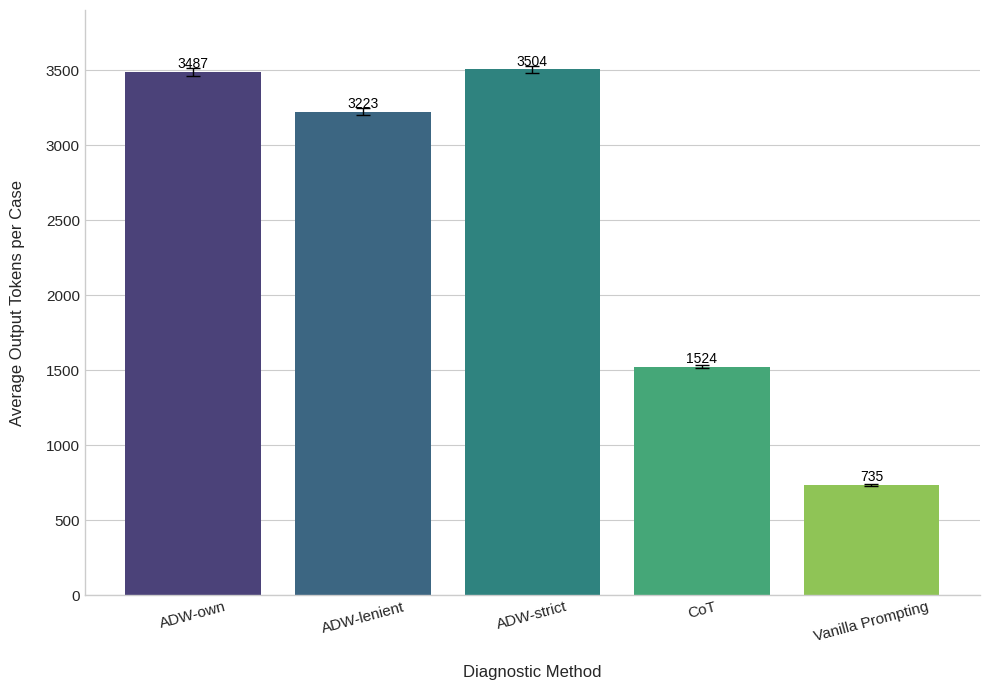

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Method': [
        'ADW-own', 'ADW-lenient', 'ADW-strict',
        'CoT', 'Vanilla Prompting'
    ],
    'Mean_Tokens': [3487.14, 3222.59, 3503.52, 1523.9, 735.14],
    'SD_Tokens': [831.49, 697.84, 660.10, 337.08, 171.94],
    'N': [800, 800, 800, 800, 800]
}
df = pd.DataFrame(data)
df['SEM'] = df['SD_Tokens'] / np.sqrt(df['N'])

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

# Use seaborn's barplot to draw the bars and calculate default error bars (if not specified)
# We'll draw our custom SEM error bars on top.
# Using `capsize` for the error bars if we were using seaborn's default yerr argument.
# Since we are plotting custom error bars, we'll handle caps manually.

# Create the bars
bars = sns.barplot(
    x='Method',
    y='Mean_Tokens',
    data=df,
    ax=ax,
    palette='viridis',
    # hue=None is correct here as you don't have a grouping variable
)

# Manually plot the error bars (SEM) on top of the bars
# The x-coordinates for the error bars correspond to the bar centers.
# Seaborn's barplot places bars at integer positions (0, 1, 2, ...)
x_coords = range(len(df['Method']))

# Plotting the SEM error bars
# ax.errorbar expects x, y, yerr. We want to plot error on top of the bars.
# We can iterate through the bars and get their x-positions.
for i, bar in enumerate(bars.patches):
    # bar.get_x() is the left edge of the bar
    # bar.get_width() is the width of the bar
    # center_x = bar.get_x() + bar.get_width() / 2
    # This is equivalent to the index 'i' when x is categorical
    center_x = i
    mean_y = df.loc[i, 'Mean_Tokens']
    sem_y = df.loc[i, 'SEM']

    # Plotting the error bar with caps
    ax.errorbar(center_x, mean_y, yerr=sem_y, fmt='none', c='black', capsize=5, linewidth=1)

# Annotate the mean values
for i, bar in enumerate(bars.patches):
    ax.text(
        bar.get_x() + bar.get_width() / 2,       # x-coordinate: center of the bar
        bar.get_height() + sem_y * 0.8,         # y-coordinate: slightly above the bar/error bar
        f'{bar.get_height():.0f}',
        ha='center',
        va='bottom',
        color='black',
        fontsize=10 # Adjust fontsize if needed
    )

#ax.set_title('Comparison of Average Output Tokens per Case', fontsize=16, pad=20)
ax.set_xlabel('Diagnostic Method', fontsize=12, labelpad=15)
ax.set_ylabel('Average Output Tokens per Case', fontsize=12, labelpad=15)
ax.tick_params(axis='x', rotation=15, labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.set_ylim(bottom=0, top=3900)

# Ensure y-axis starts from a reasonable value if means are large
# ax.set_ylim(bottom=0) # Or adjust if necessary to avoid cutting off error bars

sns.despine()
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.savefig('/media/luzhenyang/project/agent_graph_diag/statistics/tokens_counting/token_comparison_barchart.pdf', dpi=300)
plt.show()